In [ ]:
!pip install git+https://github.com/huggingface/transformers.git --user

In [1]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset

from tqdm.notebook import tqdm
from tqdm.auto import tqdm

from transformers import BertTokenizer, DistilBertTokenizer, RobertaTokenizer
from transformers import BertForSequenceClassification, DistilBertForSequenceClassification, RobertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import random


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
train = pd.read_pickle('./data/train.pkl')
test = pd.read_pickle('./data/test.pkl')

print("Size of the train data: ", len(train))
print("Size of the test data: ", len(test))


possible_labels = train["Code"].unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print(label_dict)


Size of the train data:  3464
Size of the test data:  866
{'Solution Discussion': 0, 'Expected Behaviour': 1, 'Usage': 2, 'Social Conversation': 3, 'Contribution and Commitment': 4, 'Bug Reproduction': 5, 'Motivation': 6, 'Potential New Issues and Requests': 7, 'Investigation and Exploration': 8, 'Workarounds': 9, 'Observed Bug Behaviour': 10, 'Task Progress': 11, 'Action on Issue': 12}


In [4]:
train['Code'] = train["Code"].replace(label_dict)

In [5]:
x_train, x_val, y_train, y_val = train_test_split(train, 
                                                  train["Code"], 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=train["Code"].values)

/cta/apps/opt/spack/linux-ubuntu18.04-cascadelake/gcc-10.2.0/anaconda3-2019.10-iuiptdanppsqsiwkt5zl63gqf6qrc5fv/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/cta/apps/opt/spack/linux-ubuntu18.04-cascadelake/gcc-10.2.0/anaconda3-2019.10-iuiptdanppsqsiwkt5zl63gqf6qrc5fv/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this wil

In [6]:
len(x_train), len(x_val)

(2944, 520)

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
encoded_data_train = tokenizer.batch_encode_plus(
    x_train["Text Content"].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='longest',
    truncation=True, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(x_train["Code"].values)

In [9]:
encoded_data_val = tokenizer.batch_encode_plus(
    x_val["Text Content"].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='longest',
    truncation=True,
    return_tensors='pt'
)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(x_val["Code"].values)

In [10]:
from collections import Counter
count = Counter(y_train)
 
class_count = np.array([count[i] for i in count])
 
weight = 1./class_count
 
weight

array([0.00104167, 0.00389105, 0.00184162, 0.01190476, 0.00512821,
       0.004     , 0.00598802, 0.00641026, 0.01666667, 0.01785714,
       0.01176471, 0.01123596, 0.02380952])

In [11]:
from torch.utils.data import WeightedRandomSampler

samples_weight = np.array([weight[t] for t in y_train])
samples_weight=torch.from_numpy(samples_weight)

sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [12]:
count_val = Counter(y_val)
 
class_count_val = np.array([count_val[i] for i in count_val])
 
weight_val = 1./class_count_val

samples_weight_val = np.array([weight_val[t] for t in y_val])
samples_weight_val = torch.from_numpy(samples_weight_val)

sampler_val = WeightedRandomSampler(samples_weight_val, len(samples_weight_val))

In [13]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
print(len(dataset_train), len(dataset_val))


2944 520


In [14]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [15]:

batch_size = 1

dataloader_train = DataLoader(dataset_train, 
                              sampler=sampler,
                              #sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   #sampler=SequentialSampler(dataset_val), 
                                   sampler=sampler_val,
                                   batch_size=batch_size)


In [16]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)


/cta/users/smehder/.local/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [17]:
epochs = 40

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [18]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')
    
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [19]:

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [20]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [24]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'./Models/finetuned_real_bert-base_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.6579500621838317
Validation loss: 2.512920015956535
F1 Score (Weighted): 0.3222410300942391


/cta/apps/opt/spack/linux-ubuntu18.04-cascadelake/gcc-10.2.0/anaconda3-2019.10-iuiptdanppsqsiwkt5zl63gqf6qrc5fv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 2:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.025058977753756
Validation loss: 2.7184132052622423
F1 Score (Weighted): 0.4038266351033884


Epoch 3:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6808154917769561
Validation loss: 2.640695211579749
F1 Score (Weighted): 0.4213154497921178


Epoch 4:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5057255022614117
Validation loss: 3.042022981096908
F1 Score (Weighted): 0.4619515950880711


Epoch 5:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.40867881011500257
Validation loss: 3.0698822570208204
F1 Score (Weighted): 0.4999346509543709


Epoch 6:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.3261326658554599
Validation loss: 4.180960756869007
F1 Score (Weighted): 0.4354245960949366


Epoch 7:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.26416110574846663
Validation loss: 4.65728247818368
F1 Score (Weighted): 0.37303140552084596


Epoch 8:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.2106252172754464
Validation loss: 4.725536190387209
F1 Score (Weighted): 0.42436457203736416


Epoch 9:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.20101236181309592
Validation loss: 5.434308228716156
F1 Score (Weighted): 0.41542630608673914


Epoch 10:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.17740312426985036
Validation loss: 4.67963262840165
F1 Score (Weighted): 0.48319052723625666


Epoch 11:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.1409821849839286
Validation loss: 5.054333875148289
F1 Score (Weighted): 0.4587263434641148


Epoch 12:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.1483981413516362
Validation loss: 5.971001782892761
F1 Score (Weighted): 0.37430314958087424


Epoch 13:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.16132783697463152
Validation loss: 5.470766210078459
F1 Score (Weighted): 0.4481822612234516


Epoch 14:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.13653844060434672
Validation loss: 5.561657518952408
F1 Score (Weighted): 0.4550582494593402


Epoch 15:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.1021005619467948
Validation loss: 5.641012523479708
F1 Score (Weighted): 0.43618479608129257


Epoch 16:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.07891125578202517
Validation loss: 5.573530221853738
F1 Score (Weighted): 0.4417902328992114


Epoch 17:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.07530311496943545
Validation loss: 5.9245450834658495
F1 Score (Weighted): 0.39637176699276927


Epoch 18:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.06613737371976577
Validation loss: 6.908826185206622
F1 Score (Weighted): 0.41170910743225875


Epoch 19:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.07063303844279768
Validation loss: 6.785807257345486
F1 Score (Weighted): 0.3834581496624429


Epoch 20:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.060587502986820065
Validation loss: 6.310387159365405
F1 Score (Weighted): 0.4258704171328446


Epoch 21:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.05969082308663675
Validation loss: 6.773163206528936
F1 Score (Weighted): 0.404098146859014


Epoch 22:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.06519316271822975
Validation loss: 6.601077120841831
F1 Score (Weighted): 0.38164220135123683


Epoch 23:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.06064796804360855
Validation loss: 6.070781282796142
F1 Score (Weighted): 0.4714389034500351


Epoch 24:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.056429294481814184
Validation loss: 6.126058371123164
F1 Score (Weighted): 0.4483956156717263


Epoch 25:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.06739275148288022
Validation loss: 6.357081537728624
F1 Score (Weighted): 0.44326728147187655


Epoch 26:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.04336309171170931
Validation loss: 6.262299945299287
F1 Score (Weighted): 0.4574152853603826


Epoch 27:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.03710505441862901
Validation loss: 7.158378412661704
F1 Score (Weighted): 0.3868073546327236


Epoch 28:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.043238102578604824
Validation loss: 6.968374705758117
F1 Score (Weighted): 0.4140378531085539


Epoch 29:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.05632859999326029
Validation loss: 6.675554159089511
F1 Score (Weighted): 0.4304259819115155


Epoch 30:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 30
Training loss: 0.0403382545178673
Validation loss: 6.523857240696491
F1 Score (Weighted): 0.43692978754949224


Epoch 31:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 31
Training loss: 0.028409820630339675
Validation loss: 6.427729253352597
F1 Score (Weighted): 0.4268700960963842


Epoch 32:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 32
Training loss: 0.0359348948368214
Validation loss: 6.3141895397886545
F1 Score (Weighted): 0.4686551356762736


Epoch 33:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 33
Training loss: 0.024839748518494933
Validation loss: 7.547540796012602
F1 Score (Weighted): 0.38909390949770817


Epoch 34:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 34
Training loss: 0.027067439431318684
Validation loss: 7.058982666617576
F1 Score (Weighted): 0.42090363347540216


Epoch 35:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 35
Training loss: 0.046679766830269226
Validation loss: 7.215479277773621
F1 Score (Weighted): 0.4262879283885528


Epoch 36:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 36
Training loss: 0.04160778031724544
Validation loss: 7.192671294692005
F1 Score (Weighted): 0.3886647375802934


Epoch 37:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 37
Training loss: 0.019835330317473265
Validation loss: 6.937085507948809
F1 Score (Weighted): 0.4280043006876338


Epoch 38:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 38
Training loss: 0.02437476418303406
Validation loss: 7.032572694972786
F1 Score (Weighted): 0.41707501770104355


Epoch 39:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 39
Training loss: 0.028296062481024453
Validation loss: 6.8152061551172
F1 Score (Weighted): 0.45088733162691613


Epoch 40:   0%|          | 0/2944 [00:00<?, ?it/s]


Epoch 40
Training loss: 0.019913835033216996
Validation loss: 6.259195734650393
F1 Score (Weighted): 0.48699341486416364


In [53]:
checkpoint = torch.load("./Models/finetuned_real_bert-base_epoch_40.model")
model.load_state_dict(checkpoint)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [54]:
test['Code'] = test["Code"].replace(label_dict)
encoded_data_test = tokenizer.batch_encode_plus(
    test["Text Content"].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='longest',
    truncation=True, 
    return_tensors='pt'
)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test["Code"].values)

dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

val_loss, predictions, true_vals = evaluate(dataloader_test)
val_f1 = f1_score_func(predictions, true_vals)
tqdm.write(f'Validation loss: {val_loss}')
tqdm.write(f'F1 Score (Weighted): {val_f1}')

Validation loss: 4.837932459161685
F1 Score (Weighted): 0.542849629135851


In [56]:
y_pred = []
for i in range(len(predictions)):
    y_pred.append(predictions[i].tolist().index(max(predictions[i])))
print(y_pred)

[3, 8, 11, 3, 0, 8, 6, 0, 2, 3, 8, 0, 7, 6, 2, 0, 3, 0, 0, 0, 3, 10, 0, 0, 0, 3, 0, 3, 8, 5, 0, 0, 3, 0, 3, 8, 0, 0, 8, 3, 6, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 5, 7, 0, 1, 5, 5, 8, 0, 12, 0, 8, 8, 3, 2, 0, 1, 0, 9, 0, 3, 5, 0, 3, 8, 3, 5, 0, 2, 3, 0, 0, 8, 2, 3, 0, 0, 6, 0, 11, 0, 0, 3, 5, 0, 3, 7, 0, 2, 0, 5, 6, 0, 2, 0, 3, 2, 2, 0, 0, 5, 2, 0, 2, 0, 0, 3, 0, 0, 0, 5, 3, 0, 3, 0, 8, 0, 8, 1, 8, 0, 0, 0, 5, 0, 0, 0, 6, 7, 6, 0, 0, 3, 0, 8, 0, 0, 3, 8, 3, 3, 0, 0, 7, 2, 0, 0, 3, 12, 5, 3, 3, 0, 7, 7, 0, 0, 8, 0, 2, 2, 11, 5, 3, 3, 2, 3, 8, 3, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 3, 7, 3, 3, 0, 3, 0, 5, 0, 0, 1, 3, 6, 4, 11, 3, 0, 0, 5, 0, 0, 3, 2, 0, 0, 0, 5, 8, 8, 2, 8, 0, 0, 2, 0, 0, 7, 3, 0, 0, 0, 5, 8, 0, 2, 12, 0, 0, 3, 3, 3, 2, 0, 0, 3, 0, 3, 3, 0, 5, 3, 6, 3, 0, 0, 0, 8, 8, 6, 5, 3, 9, 3, 2, 0, 8, 3, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 7, 5, 0, 3, 0, 0, 3, 0, 0, 8, 5, 0, 5, 0, 8, 0, 0, 11, 0, 0, 8, 0, 12, 2, 0, 0, 0, 2, 0, 0, 10, 0, 2, 0, 3, 0, 0, 3, 1, 0, 2, 11, 0, 3, 0, 0, 2, 0, 0, 0, 0, 

In [57]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(true_vals, y_pred)
print(cf_matrix)

[[207   2  12   8   1   8   9   4  21   0   3   7   0]
 [  9  10   0   3   0   0   1   1   1   0   0   0   0]
 [ 31   0  35   3   0   0   2   0   2   0   1   0   0]
 [ 19   0   2 128   0   0   3   4   1   0   0   2   0]
 [  4   0   0   5   7   0   0   0   0   0   0   1   0]
 [ 12   0   1   1   0  22   0   4   7   0   2   0   0]
 [ 33   3   3   4   0   0  13   1   0   0   0   0   1]
 [ 24   1   1   1   1   2   1  12   3   0   0   0   0]
 [ 29   0   6   1   0   6   1   2  28   0   2   0   0]
 [  8   1   0   3   0   1   0   0   1   3   0   0   1]
 [  8   1   1   2   0   5   0   1   4   0   4   0   0]
 [  8   0   1   1   2   0   1   3   1   0   0   8   0]
 [  2   0   0   0   1   0   0   0   0   0   0   1   8]]


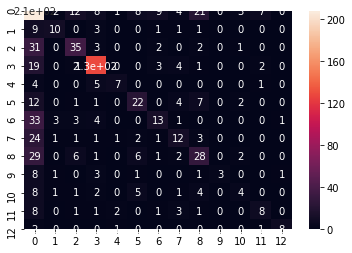

In [58]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

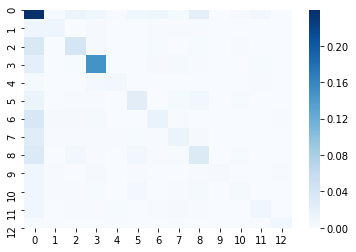

In [59]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.2%', cmap='Blues')

In [60]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(true_vals, y_pred)

for label, i in label_dict.items():
    print('{}: \t\tprecision: {:.2f}, recall: {:.2f}, fscore: {:.2f}, support: {}'.format(label, precision[i], recall[i], fscore[i], support[i]))

Solution Discussion: 		precision: 0.53, recall: 0.73, fscore: 0.61, support: 282
Expected Behaviour: 		precision: 0.56, recall: 0.40, fscore: 0.47, support: 25
Usage: 		precision: 0.56, recall: 0.47, fscore: 0.51, support: 74
Social Conversation: 		precision: 0.80, recall: 0.81, fscore: 0.80, support: 159
Contribution and Commitment: 		precision: 0.58, recall: 0.41, fscore: 0.48, support: 17
Bug Reproduction: 		precision: 0.50, recall: 0.45, fscore: 0.47, support: 49
Motivation: 		precision: 0.42, recall: 0.22, fscore: 0.29, support: 58
Potential New Issues and Requests: 		precision: 0.38, recall: 0.26, fscore: 0.31, support: 46
Investigation and Exploration: 		precision: 0.41, recall: 0.37, fscore: 0.39, support: 75
Workarounds: 		precision: 1.00, recall: 0.17, fscore: 0.29, support: 18
Observed Bug Behaviour: 		precision: 0.33, recall: 0.15, fscore: 0.21, support: 26
Task Progress: 		precision: 0.42, recall: 0.32, fscore: 0.36, support: 25
Action on Issue: 		precision: 0.80, recall: 

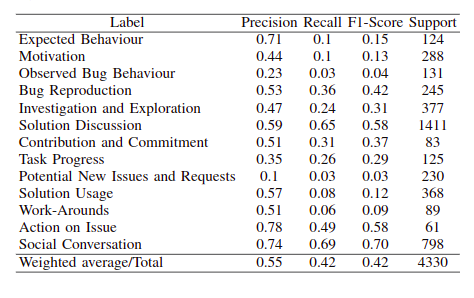

In [49]:
label_dict.keys()

dict_keys(['Solution Discussion', 'Expected Behaviour', 'Usage', 'Social Conversation', 'Contribution and Commitment', 'Bug Reproduction', 'Motivation', 'Potential New Issues and Requests', 'Investigation and Exploration', 'Workarounds', 'Observed Bug Behaviour', 'Task Progress', 'Action on Issue'])